# Price Regression with LightGBM

Problem definition: Build an algorithm which predicts article prices based on product characteristerics.

**Keywords**: LightGBM, regression modelling, price prediction, Vinted

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import plotly.express as px
import os
import json
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
#import joblib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import shap
from scipy.stats import kstest

In [40]:
def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return


load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

# Load a sample dataset
def load_data():
    engine = create_engine(aws_rds_url)
    sql_query = f"""SELECT size_title, color1, brand_title, price_numeric, status, catalog_id, package_size_id, country, product_id
                    FROM public.tracking_staging 
                    LIMIT 500000
                    """
    df = pd.read_sql(sql_query, engine)
    return (df)

data = load_data()
data.head(5)

Because the source table is a staging table, there are a lot of repeated records (only with different dates). We will keep only the last row per product_id.

In [42]:
data.drop_duplicates(subset='product_id', inplace=True, keep= "last")
data

,size_title,color1,brand_title,price_numeric,status,catalog_id,package_size_id,country,product_id
16,,None,,5,Muito bom,2336,1,Espagne,4100431749
43,45,Branco,Calvin Klein,69,Novo com etiquetas,1242,3,France,4131293009
77,43,Castanho,Sebago,89,Novo com etiquetas,2656,3,France,3940328884
135,,Branco,,5,Bom,1961,8,France,4094888069
136,,Multi,,3,Muito bom,1956,1,France,4094253329
...,...,...,...,...,...,...,...,...,...
499995,,None,,2,Bom,2322,1,France,4198508309
499996,Tamanho único,Creme,,15,Muito bom,1773,3,France,4197629069
499997,,Branco,,50,Muito bom,2924,3,France,4182308625
499998,,None,,10,Muito bom,2351,3,France,4112524014


There is a huge loss of data when considering unique product_ids. Since the purpose of the pipeline is to track products accross time as well, the same product might have a registry for each day.

In [43]:
data.isnull().sum()

size_title            0
color1             7467
brand_title           0
price_numeric         0
status                0
catalog_id            0
package_size_id       0
country               0
product_id            0
dtype: int64

## Issues so far:

- catalog_id is int64, other predictors are object. Need to convert them to categorical before feeding to LightGBM
- color1_id has missing values (why?)
    - after inspecting and being knowledgeable about the data, there are articles which by nature do not have colors (such as books)
- the most popular size_title is ""
    - after inspecting I realize this has to do with "sizeless" items such as books as well
- the most popular brand_title is ""
    - this means the article doesn't have a brand. this can have several reasons, not only due to the misc items but also I believe Vinted allowed the user to publish items with empty brands at some point (I haven't confirmed this)
- size_title has 230 unique values which is a lot, let's take a look into that later
    - why is that?
- brand_title has 4.7k unique values which is also a lot
    - why is that?
## Approaches

- change dtypes
- create a dummy color1_id and assign it to articles missing color1_id (filling with value 0)
- replacing "" size_title with "no_size" for better semantic representation (otherwise users are left to guess what it means)
- replacing ""brand_title with "no_brand" for the same reason

In [44]:
data["size_title"] = data["size_title"].replace("", "no_size")
data["brand_title"] = data["brand_title"].replace("", "no_brand")
data["color1"] = data["color1"].fillna("no_color")
data.isnull().sum()

size_title         0
color1             0
brand_title        0
price_numeric      0
status             0
catalog_id         0
package_size_id    0
country            0
product_id         0
dtype: int64

In [45]:
data = data.dropna()

## Taking a deeper look into size title

Size title has unbalanced labels.
- Sizes can be further divided into product types. For instance, we have:
    - M, XL, S, etc which are the standard clothing sizes
    - no_size for the products which do not have size labels
    - numeric sizes (40, 41) which refers to footwear
    - kids sizes (8 anos, 12 anos, etc)
    - cup sizes (95D, 80B)
    - jewelry (which im assuming 30 mm diameter refers to)
    - volume units (40 x 45 cm)
    - weight units (9-18kgs)
    - jeans sizes (waist measurements W33)

In [46]:
# Assuming your DataFrame is called data
fig = px.bar(data['size_title'].value_counts(), 
             x=data['size_title'].value_counts().index, 
             y=data['size_title'].value_counts().values,
             labels={'x': 'Size Title', 'y': 'Count'},
             title='Count of Size Title')
fig

## Taking a deeper look into brand title

Brand titles has too many brands.
- A lot of the brands aren't even brands (such as dri-fit, b(?), GYM, MI(?), etc)
- There are brands that mean the same thing (such as local, locale or any other meaning of thrift clothing)

In [47]:
fig = px.bar(data['brand_title'].value_counts(), 
             x=data['brand_title'].value_counts().index, 
             y=data['brand_title'].value_counts().values,
             labels={'x': 'Brand Title', 'y': 'Count'},
             title='Count of Brand Title')
fig

## Approaches to size titles

- Feature engineering
    - We can easily split garments from shoes, if we consider shoes have only numeric values assigned to sizes
- Remove size classes below a certain threshold

In [48]:
label_counts = data['size_title'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['size_title'].isin(labels_more_than_100)]
data['size_title'].unique()

array(['no_size', '45', '43', 'S / 36 / 8', 'M / 38 / 10', 'L', 'S',
       '14 anos / 164 cm', '8 anos / 128 cm', 'XL', 'M', 'XXXL / 46 / 18',
       '9-12 meses / 74\xa0cm', '3-6 meses / 62\xa0cm',
       '6-9 meses / 68 cm', 'L / 40 / 12', '37', 'Tamanho único', '38',
       'XXL / 44 / 16', '10 anos / 140 cm', 'XS', 'XXS / 32 / 4',
       'XS / 34 / 6', '36', '39', '12 anos / 152 cm', '6 anos / 116 cm',
       '12-18 meses / 80\xa0cm', '42,5', '40', 'XXL', '13 anos / 158 cm',
       '4 anos / 104 cm', '3 anos / 98 cm', '41', '42', 'XL / 42 / 14',
       '5 anos / 110 cm', '24-36 meses / 92 cm', '1-3 meses / 56\xa0cm',
       '18-24 meses / 86\xa0cm', 'Outro', '16 anos / 176 cm', '44',
       '4XL / 48 / 20', '11 anos / 146 cm', 'PT 42 | W32', 'PT 40 | W30',
       '7 anos / 122 cm', 'Até 1 mês / 50\xa0cm', '9 anos / 134 cm'],
      dtype=object)

In [49]:
fig = px.bar(data['brand_title'].value_counts(), 
             x=data['brand_title'].value_counts().index, 
             y=data['brand_title'].value_counts().values,
             labels={'x': 'Brand Title', 'y': 'Count'},
             title='Count of Brand Title')
fig

## Approaches to brand titles

- Remove size classes below a certain threshold

In [50]:
label_counts = data['brand_title'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['brand_title'].isin(labels_more_than_100)]
data['brand_title'].unique()

array(['no_brand', 'Calvin Klein', 'Decathlon', 'Local', 'Ralph Lauren',
       'Primark', 'Vintage', 'Gémo', 'Lacoste', "Levi's", 'Carhartt',
       'Puma', 'Kiabi', 'Camaïeu', 'Zara', 'United Colors of Benetton',
       'Stradivarius', 'Jack & Jones', 'Shein', 'H&M', 'Jennyfer',
       'Tommy Hilfiger', 'Orchestra', 'Pull & Bear', 'Nike', 'Jordan',
       'adidas', 'Timberland', 'Bershka', 'Donna', 'In Extenso',
       'Hollister', 'Mango', 'Etam', 'Promod', 'The North Face', 'Disney',
       'GUESS', 'ONLY', 'Champion', 'Scarpe', "Tape à l'œil",
       'Vintage Dressing', 'Lefties', 'Pimkie', 'Vans', 'TEX',
       'Cache Cache', 'Inconnu', 'sans marque'], dtype=object)

In [51]:
label_counts = data['catalog_id'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['catalog_id'].isin(labels_more_than_100)]
data["catalog_id"].unique()

array([2336, 1242, 1806, 1813, 2339, 2355, 2346, 2349, 2350, 2363, 2364,
       1204, 1844,  228, 1803,  196,  532,  267, 1056, 1043, 1099,  222,
       1042, 1821, 1662, 1809, 2343, 1672, 2632,  584, 2362, 2338,   18,
       1845, 1065,  225, 1807,  221, 1041, 1055,  198, 1535, 1554, 1811,
        223, 2333, 2337, 2360,  199,  534, 1812, 2342, 1066, 1801,  529,
        194,  190,  156,  197,  224, 1071, 2351, 1059,  163, 2344,  178,
       1223, 2328,  164], dtype=int64)

In [52]:
from sklearn.model_selection import train_test_split
# LightGBM also can handle categorical data directly We go to probe its inner method

# Transform categorical features into the appropriate type that is expected by LightGBM
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')
data["catalog_id"] = data["catalog_id"].astype("category")
data["package_size_id"] = data["package_size_id"].astype("category")
data.describe()


,price_numeric,product_id
count,13750.000000,1.375000e+04
mean,12.501891,3.916141e+09
std,24.823091,6.654657e+08
min,1.000000,6.155628e+07
25%,3.000000,3.994917e+09
50%,5.000000,4.110502e+09
75%,12.000000,4.252169e+09
max,585.000000,4.376377e+09


In [53]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["price_numeric"]), 
                                                    data["price_numeric"], 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train.head(5)

,size_title,color1,brand_title,status,catalog_id,package_size_id,country,product_id
359359,L,Azul-marinho,Lacoste,Muito bom,1809,1,Italie,4341961902
268152,S / 36 / 8,Fúcsia,no_brand,Muito bom,534,1,France,4264395917
495278,M / 38 / 10,Preto,Shein,Muito bom,224,1,Belgique,4015485677
497615,38,Preto,Vans,Muito bom,2632,3,Spagna,4365071152
246712,M / 38 / 10,Branco,no_brand,Muito bom,1065,1,France,4137437846


In [54]:
d_train=lgb.Dataset(X_train, 
                    label=y_train,
                    params={"max_bin":128})

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error    
    'n_estimators': 600,
    'max_depth': 18,
    'num_leaves': 2**6,
    'learning_rate': 0.01
}

clf=lgb.train(params,
              d_train) 

# Prediction on the valid set
y_pred=clf.predict(X_test)

# postprocess function
y_pred = y_pred.astype(np.int16)
errors = y_pred - y_test

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 11000, number of used features: 8
[LightGBM] [Info] Start training from score 12.508364
Mean Squared Error: 337.1370909090909


In [55]:
results = pd.DataFrame([y_pred, y_test]).T
results.columns = ["Prediction", "Test"]
results

,Prediction,Test
0,5,8
1,10,10
2,6,3
3,19,10
4,8,10
...,...,...
2745,4,9
2746,6,2
2747,3,6
2748,22,14


Text(0.5, 1.0, 'Actual vs. Predicted')

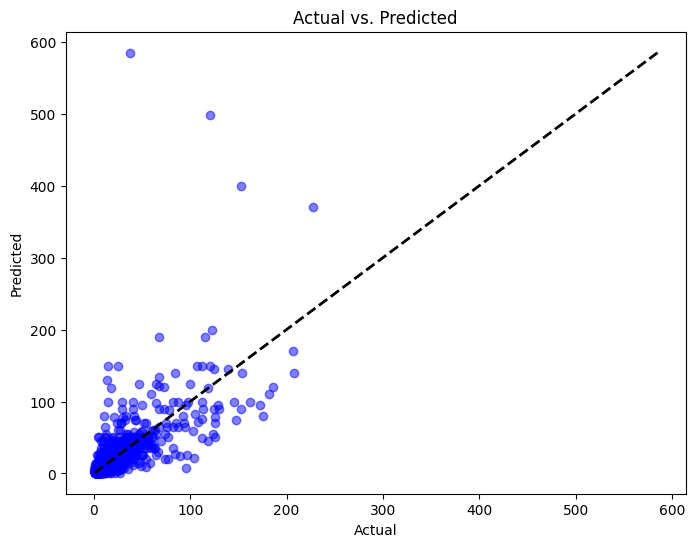

In [56]:
# y_pred/y_test plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, color='blue', alpha=0.5)
plt.plot([y_test.min(), 
          y_test.max()], 
          [y_test.min(), 
           y_test.max()], 
           'k--', 
           lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

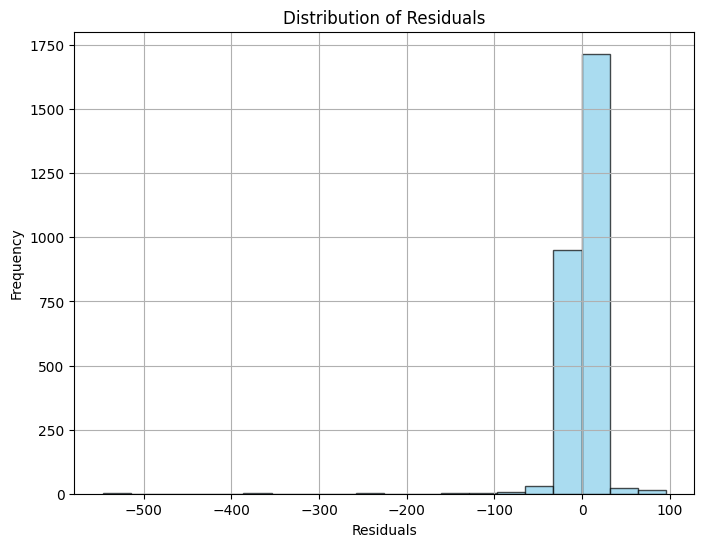

In [57]:
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)

#### Q-Q Plot

A visual representation of residue normality.

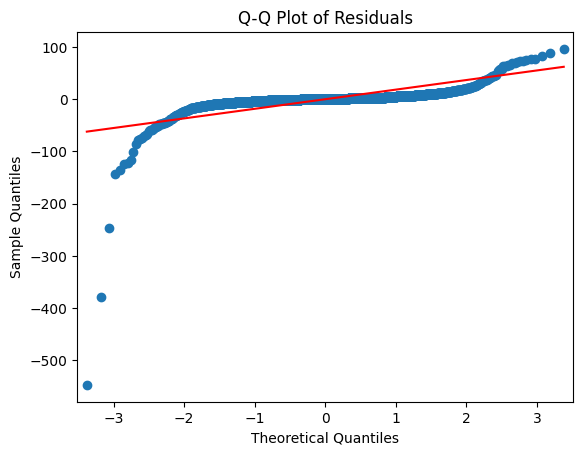

In [60]:
# Q-Q plot of residuals
sm.qqplot(errors, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

#### Kolmogorov-Smirnov Test

KS test to test residues for normality.

In [61]:
ks_test_stat, ks_p_value = kstest(errors, 'norm')
print("\nKolmogorov-Smirnov Test:")
print("Test Statistic:", ks_test_stat)
print("p-value:", ks_p_value)


Kolmogorov-Smirnov Test:
Test Statistic: 0.35079929152308836
p-value: 4.577896821001356e-303


The Kolmogorov-Smirnov test is a statistical test used to assess whether a sample comes from a specific distribution (in this case, a normal distribution).

We reject the null hypothesis that the errors are normaly distributed.

### SHapley Additive exPlanations

SHAP or SHapley Additive exPlanations is a model agnostic framework which provides interpretability into individual models and feature importance. In short, SHAP accounts for the marginal contribution of each feature to the prediction scores.

We use TreeExplainer because it is used for explaining predictions from tree based models such as LightGBM.

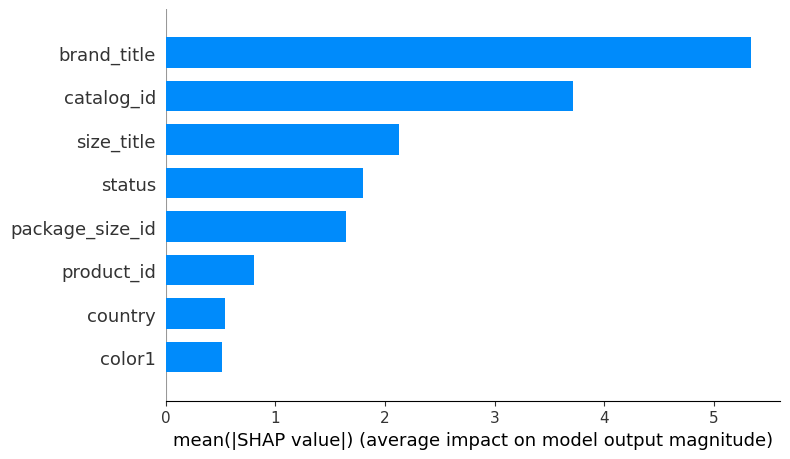

In [58]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
pd.DataFrame(shap_values, columns= X_test.columns).apply(np.abs).mean(axis = 0)
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_test.columns,
                  plot_type = "bar")

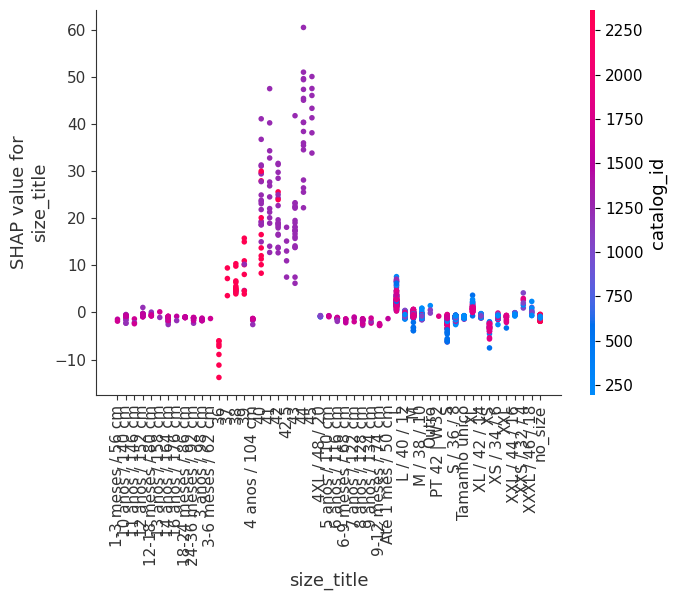

In [59]:
shap.dependence_plot("size_title", shap_values, X_test, interaction_index="catalog_id")

### Conclusions

- We developed a model with around 200-300 RMSE
- Our model doesn't yield robust results, as they vary a lot between runs
- As expected, one of the best predictors to price is brand title followed by the product catalog.
- The SHAP values per size_title with biggest value are linked to shoe sizes
- The SHAP values per size_title with biggest negative value are linked to women sizes
- In order to optimize revenue brand_title and catalogs are by far the best predictors of future revenue

Note: It's really tough to say which size title predicts higher price because there are a lot of confounding variables (namely product catalogs).

### Future work

- Preprocess the country labels into unique labels (France = Francia)
- Add cross validation to get more robust results
- Add hyperparam tuning
- Add stratified sampling and minimum size per labels in the SQL queries